In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = "D:/CS4243_miniproj/train_dataset/"

In [25]:
# Transformations for the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

In [26]:
# Hyperparameters
num_epochs = 100
patience = 50  # Stop if there is no improvement after 5 epochs
batch_size = 32
learning_rate = 0.001
num_classes = len(datasets.ImageFolder(root + "dataset2").classes)  # Number of unique characters

In [27]:
# Load the dataset
dataset = datasets.ImageFolder(root=root+'dataset2', transform=transform)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# Define a CNN model
class CharacterCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for the first conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for the second conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for the third conv layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Adjusted for third conv layer output size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # Conv1 + BN + LeakyReLU + Pool
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))  # Conv2 + BN + LeakyReLU + Pool
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))  # Conv3 + BN + LeakyReLU + Pool
        x = x.view(-1, 128 * 3 * 3)  # Flatten
        x = F.leaky_relu(self.fc1(x))  # Fully connected layer 1 with LeakyReLU
        x = self.dropout(x)  # Dropout for regularization
        x = F.leaky_relu(self.fc2(x))  # Fully connected layer 2 with LeakyReLU
        x = self.fc3(x)  # Output layer
        return x

In [29]:
model = CharacterCNN(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [30]:
# Variables to track losses
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
best_accuracy = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

# Training with early stopping
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate validation accuracy
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_loss += loss.item()  # Accumulate validation loss

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * accuracy}%, Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')

    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Check if accuracy improved
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
        early_stop_counter = 0  # Reset early stopping counter
    else:
        early_stop_counter += 1

    # Stop if no improvement after patience epochs
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)
print("Best model loaded with accuracy:", best_accuracy * 100)

Epoch [1/100], Training Loss: 1.4761638730693767, Validation Loss: 0.7930279082455342, Validation Accuracy: 75.82629316733363%, Learning Rate: 0.001
Epoch [2/100], Training Loss: 0.8881446352290316, Validation Loss: 0.6610129321638442, Validation Accuracy: 79.76878612716763%, Learning Rate: 0.001
Epoch [3/100], Training Loss: 0.734148919935475, Validation Loss: 0.5843829845930163, Validation Accuracy: 81.71038980287535%, Learning Rate: 0.001
Epoch [4/100], Training Loss: 0.6512464292135567, Validation Loss: 0.5548288393500856, Validation Accuracy: 83.01467318808359%, Learning Rate: 0.001
Epoch [5/100], Training Loss: 0.5833071767312796, Validation Loss: 0.520273842800285, Validation Accuracy: 83.5482436638506%, Learning Rate: 0.001
Epoch [6/100], Training Loss: 0.526765341477654, Validation Loss: 0.5175218650656289, Validation Accuracy: 84.12627834593152%, Learning Rate: 0.001
Epoch [7/100], Training Loss: 0.49238884947770295, Validation Loss: 0.4864413432106023, Validation Accuracy: 8

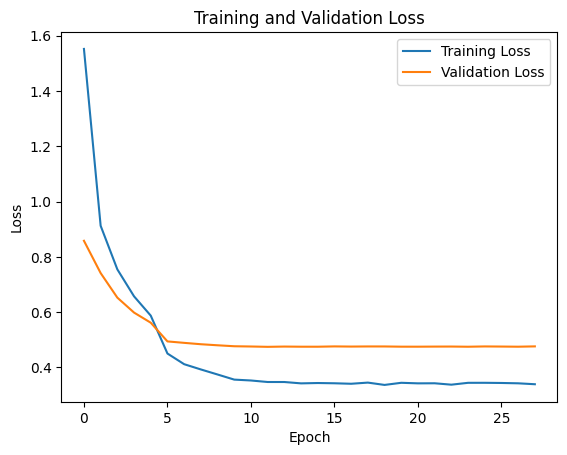

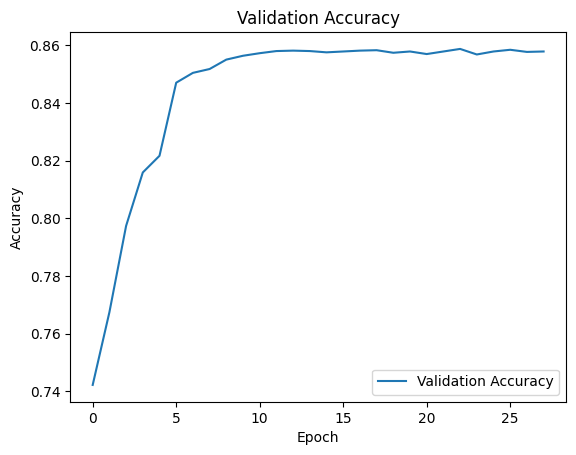

In [ ]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot validation accuracy
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {100 * accuracy}%')

# Call evaluate function after training
evaluate(model, test_loader)

Test Accuracy: 85.87520379427895%


In [ ]:
# Save the model
model_path = "character_cnn4.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to character_cnn3.pth


In [ ]:
# Create a new instance of the model
model = CharacterCNN(num_classes)
 # Set the model to evaluation mode